In [1]:
# Required libraries :
# tensorflow
# yfinance
# matplotlib
# pandas
# numpy

Install all the above mentioned libraries using <b>'pip'</b>. <br>
For example to install <b>yfinance</b>, run : `pip install yfinance`    

### Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler

### Deciding two things:
1. the <b>dates</b> over which we want to collect the data
2. the <b>stock symbol</b> for which we want to train the model

In [3]:
# we chose the 'ITC' stock over the NSE market over a period of 10 years
start = '2012-01-01'
end = '2022-12-21'
stock = 'ITC.NS' 

In [4]:
#downloading the data
data = yf.download(stock,start,end)

[*********************100%%**********************]  1 of 1 completed


### EDA

In [5]:
# create a new pandas dataframe using the data received from yfinance
prices = pd.DataFrame(data)
prices.sample(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-06-28,262.000000,264.000000,259.000000,260.500000,215.898712,14637010
2017-03-14,266.200012,271.649994,265.200012,267.100006,213.988358,17821655
2022-07-11,293.000000,296.950012,292.049988,295.000000,288.641510,12352667
2020-07-15,196.350006,200.000000,194.500000,198.699997,176.464310,23776757
2015-12-28,215.133331,218.033340,214.966660,217.466660,173.254608,9082360
2021-10-14,253.250000,261.850006,250.350006,256.549988,239.727646,85406902
2013-05-08,224.500000,229.866669,222.899994,228.533340,172.720993,7133002
2020-12-18,213.100006,215.949997,209.750000,214.500000,190.496216,23775053
2015-04-24,228.000000,233.300003,227.433334,231.966660,181.181854,17318818


In [6]:
#checking null values
prices.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [7]:
prices.shape

(2705, 6)

In [8]:
#add a new row to indicate the indeces
prices.reset_index(inplace=True)

In [9]:
prices.sample(10)

,Date,Open,High,Low,Close,Adj Close,Volume
846,2015-06-12,197.866669,200.100006,196.666672,198.366669,158.037704,8332143
1901,2019-09-25,255.100006,256.250000,242.699997,247.550003,209.096313,20597095
1180,2016-10-21,239.000000,241.149994,238.750000,240.149994,192.397247,10592011
1965,2019-12-31,238.550003,238.949997,237.399994,237.699997,200.776367,7142051
1982,2020-01-23,238.100006,238.750000,236.899994,237.899994,200.945312,6120434
2190,2020-11-23,192.000000,192.500000,188.649994,190.850006,169.492798,23180456
1695,2018-11-20,285.000000,286.649994,281.799988,283.850006,235.250854,7796633
2607,2022-07-28,304.899994,305.200012,302.399994,303.450012,296.909393,10839070
2214,2020-12-29,210.500000,213.500000,210.100006,211.550003,187.876312,26546469
892,2015-08-17,212.866669,213.199997,210.333328,211.266663,168.315079,4328919


In [10]:
prices.shape

(2705, 7)

as we can see, a new column has been added and the <b>shape[1]</b> increased from *6* to *7*

### Prediction strategy
Our model will be trained to predict the price of a particular stock using the <b>moving average</b> of the same for the past *100* days.<br>
This implies that the fluctuations in the last *100* days of the price will be studied and the price for the *101*st day will be predicted using that.

### Plotting the moving averages

In [11]:
#calculating the moving average using rolling() function and finding the mean over a period of 100 days (window size =100)
ma_100=prices.Close.rolling(100).mean()

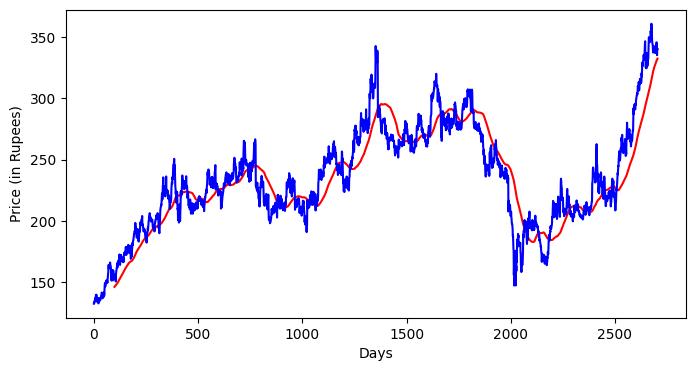

In [12]:
plt.figure(figsize=(8,4))
plt.plot(ma_100,'r')
plt.plot(prices['Close'],'b')
plt.ylabel("Price (in Rupees)")
plt.xlabel("Days")
plt.show()

In [13]:
#Calculating the moving average of 200 days
ma_200= prices['Close'].rolling(200).mean()

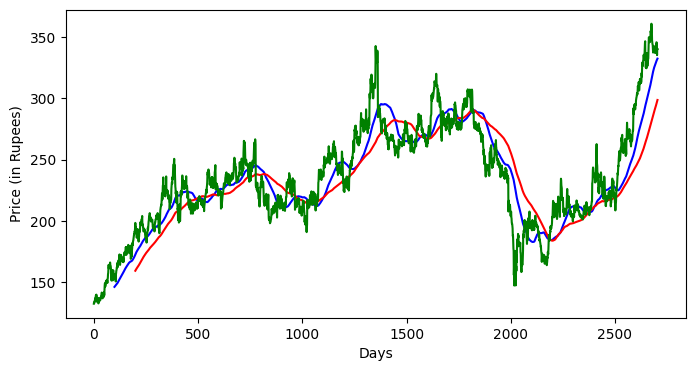

In [14]:
plt.figure(figsize=(8,4))
plt.plot(ma_100,'b')
plt.plot(ma_200,'r')
plt.plot(prices['Close'],'g')
plt.ylabel("Price (in Rupees)")
plt.xlabel("Days")
plt.show()

### Splitting the dataset into training and testing

In [15]:
#adding the first 80% of the data values into training set and the rest 20% into test set
data_train = prices['Close'][0:int(len(prices)*0.80)]
data_test = prices['Close'][int(len(prices)*0.80):len(prices)]

In [16]:
#viewing the first 5 values of the 
data_train.head()

0    132.433334
1    133.566666
2    133.033340
3    133.199997
4    134.733337
Name: Close, dtype: float64

In [17]:
data_test.head()

2164    165.699997
2165    168.250000
2166    167.449997
2167    167.649994
2168    168.550003
Name: Close, dtype: float64

In [18]:
print(data_train.shape,data_test.shape)

(2164,) (541,)


In [19]:
#scaling down the training and test set values to lie b/w 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))

In [20]:
#reshaping the training dataset to form a 2d array
data_train = np.array(data_train)
data_train=data_train.reshape(-1,1)
data_train

array([[132.43333435],
       [133.56666565],
       [133.03334045],
       ...,
       [170.1499939 ],
       [167.80000305],
       [165.05000305]])

In [21]:
data_train_scale = scaler.fit_transform(data_train)

In [22]:
data_train_scale

array([[0.        ],
       [0.0053951 ],
       [0.00285627],
       ...,
       [0.17954614],
       [0.16835926],
       [0.15526818]])

In [23]:
data_test = np.array(data_test)
data_test = data_test.reshape(-1,1)
data_test[:10]

array([[165.69999695],
       [168.25      ],
       [167.44999695],
       [167.6499939 ],
       [168.55000305],
       [170.75      ],
       [168.55000305],
       [167.19999695],
       [165.5       ],
       [163.8500061 ]])

In [24]:
data_test_scale = scaler.fit_transform(data_test)

In [25]:
data_test_scale[10:20]

array([[0.00711198],
       [0.014732  ],
       [0.03175006],
       [0.03022604],
       [0.05537208],
       [0.05130805],
       [0.04546607],
       [0.07366015],
       [0.1089662 ],
       [0.12268221]])

we take the data from past 100 days each time to predict the price of stock for the 101th day

In [26]:
x=[]
y=[]
for i in range(100,data_train_scale.shape[0]):
    x.append(data_train_scale[i-100:i])
    y.append(data_train_scale[i,0])

### Model Creation

In [27]:
#will continue from here